In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import folium
from folium.plugins import HeatMap
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv
/kaggle/input/global-weather-repository/state.db


In [3]:
file_path = '/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv'
df = pd.read_csv(file_path)

In [4]:
df.fillna(df.mean(numeric_only=True), inplace=True)  # Fill numeric NaNs with column mean
df.fillna('Unknown', inplace=True)  # Fill non-numeric NaNs with 'Unknown'

# Handle Outliers
def remove_outliers(col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

for col in ['temperature_celsius', 'precip_mm', 'humidity']:
    remove_outliers(col)

# Normalize Data
scaler = MinMaxScaler()
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [5]:
def detect_and_rank_anomalies_by_country(data, column, threshold=1.5):
    mean_val = data[column].mean()
    std_dev = data[column].std()
    
    # Identify anomalies
    anomalies_mask = np.abs(data[column] - mean_val) > threshold * std_dev
    anomalies = data[anomalies_mask]
    
    # Count anomalies per country
    country_anomaly_counts = (
        anomalies.groupby('country')
        .size()
        .reset_index(name='anomaly_count')
        .sort_values(by='anomaly_count', ascending=False)
    )
    
    return country_anomaly_counts, anomalies

# Example usage
country_anomaly_counts, temperature_anomalies = detect_and_rank_anomalies_by_country(df, 'temperature_celsius')
print("Countries Ranked by Temperature Anomalies:")
print(country_anomaly_counts)

print("\nDetailed Temperature Anomalies:")
print(temperature_anomalies[['temperature_celsius', 'country', 'latitude', 'longitude']])

# Spatial Analysis
def create_heatmap(data, latitude_col, longitude_col, value_col):
    map_center = [data[latitude_col].mean(), data[longitude_col].mean()]
    heatmap_map = folium.Map(location=map_center, zoom_start=2)

    heat_data = data[[latitude_col, longitude_col, value_col]].dropna()
    heat_data = heat_data.values.tolist()

    HeatMap(heat_data, radius=8, blur=6, max_zoom=13).add_to(heatmap_map)
    return heatmap_map

print("Creating Heatmap for Spatial Analysis...")
heatmap = create_heatmap(df, 'latitude', 'longitude', 'temperature_celsius')
heatmap.save('temperature_heatmap.html')
print("Heatmap saved to 'temperature_heatmap.html'")

Countries Ranked by Temperature Anomalies:
                      country  anomaly_count
44                    Iceland            193
17                   Bulgaria            174
46                       Iran            152
12                    Belgium            149
108  United States of America            138
..                        ...            ...
75                    Nigeria              1
71                    Namibia              1
70                    Myanmar              1
64                   Marrocos              1
112                    Zambia              1

[113 rows x 2 columns]

Detailed Temperature Anomalies:
       temperature_celsius                   country  latitude  longitude
3                 0.104358                   Andorra  0.794689   0.498617
6                 0.143349                 Argentina  0.063632   0.328791
8                 0.166284                 Australia  0.057089   0.915355
13                0.840596                Bangladesh  0.616596  

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import shap

def analyze_air_quality_correlations(df):
    """
    Analyze correlations between air quality parameters and weather conditions
    """
    # Select relevant columns for analysis
    air_quality_cols = [col for col in df.columns if 'air_quality' in col]
    weather_cols = ['temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb', 
                   'cloud', 'visibility_km']
    
    analysis_cols = air_quality_cols + weather_cols
    
    # Calculate correlation matrix
    correlation_matrix = df[analysis_cols].corr()
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Air Quality and Weather Parameters')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

def analyze_aqi_trends(df):
    """
    Analyze AQI trends and their relationship with temperature and humidity
    """
    # Calculate mean air quality parameters by temperature bins
    df['temp_bins'] = pd.qcut(df['temperature_celsius'], q=5)
    aqi_by_temp = df.groupby('temp_bins')[['air_quality_PM2.5', 'air_quality_PM10', 
                                          'air_quality_Ozone']].mean()
    
    # Plot relationships
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Temperature vs AQI parameters
    aqi_by_temp.plot(kind='bar', ax=ax1)
    ax1.set_title('Air Quality Parameters vs Temperature Ranges')
    ax1.set_xlabel('Temperature Range')
    ax1.set_ylabel('Concentration')
    
    # Humidity vs AQI scatter plot
    sns.scatterplot(data=df, x='humidity', y='air_quality_PM2.5', 
                   alpha=0.5, ax=ax2)
    ax2.set_title('Humidity vs PM2.5 Levels')
    
    plt.tight_layout()
    plt.show()

def generate_environmental_report(df):
    """
    Generate a comprehensive environmental analysis report
    """
    # Air quality summary statistics
    aqi_summary = df[[col for col in df.columns if 'air_quality' in col]].describe()
    
    # Calculate average air quality metrics by location
    location_aqi = df.groupby('location_name')[[col for col in df.columns 
                                               if 'air_quality' in col]].mean()
    
    # Identify locations with highest and lowest air quality
    worst_aqi = location_aqi.sort_values('air_quality_PM2.5', ascending=False).head()
    best_aqi = location_aqi.sort_values('air_quality_PM2.5').head()
    
    return {
        'aqi_summary': aqi_summary,
        'worst_aqi_locations': worst_aqi,
        'best_aqi_locations': best_aqi
    }

           latitude     longitude  last_updated_epoch  temperature_celsius  \
count  49890.000000  49890.000000        49890.000000         49890.000000   
mean       0.573171      0.556971            0.500460             0.488371   
std        0.232157      0.185631            0.290871             0.203644   
min        0.000000      0.000000            0.000000             0.000000   
25%        0.427217      0.476694            0.245695             0.375000   
50%        0.555239      0.560126            0.502046             0.540138   
75%        0.774775      0.637041            0.750699             0.625000   
max        1.000000      1.000000            1.000000             1.000000   

       temperature_fahrenheit      wind_mph      wind_kph   wind_degree  \
count            49890.000000  49890.000000  49890.000000  49890.000000   
mean                 0.644677      0.003311      0.003293      0.473074   
std                  0.124640      0.005332      0.005332      0.287316 

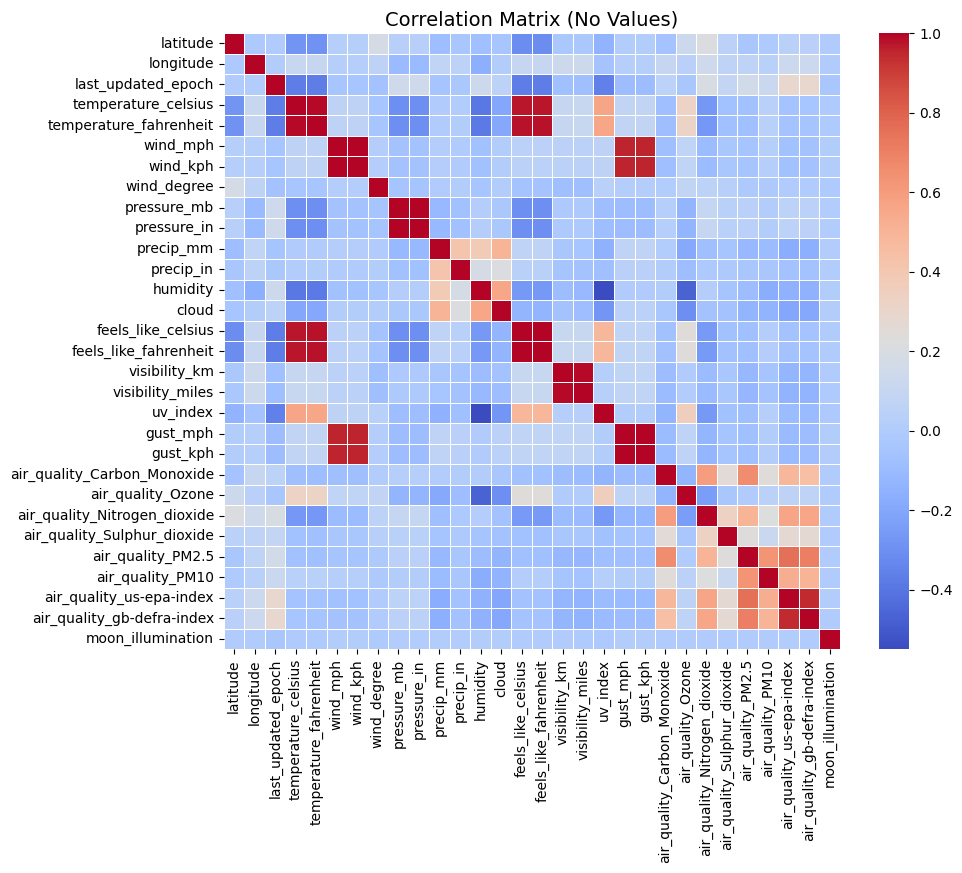

In [ ]:
# Basic stats and correlation
print(df.describe())

# Numeric correlation
numeric_data = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True, square=True, linewidths=0.5)
plt.title("Correlation Matrix (No Values)", fontsize=14)
plt.show()

# # Visualize specific relationships (e.g., PM2.5 vs temperature)
# sns.scatterplot(x=df['air_quality_PM2.5'], y=df['temperature_celsius'], hue=df['uv_index'])
# plt.title('PM2.5 vs Temperature with UV Index as Hue')
# plt.xlabel('PM2.5')
# plt.ylabel('Temperature (Celsius)')
# plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


KeyboardInterrupt: 

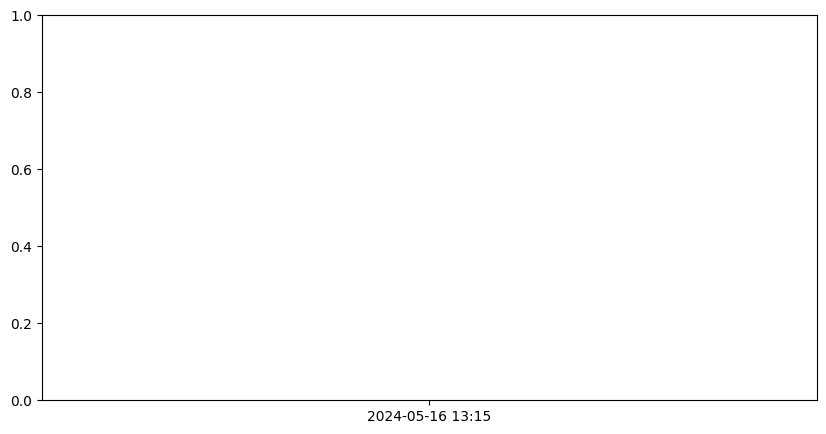

In [23]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='last_updated', y='temperature_celsius', data=df)
plt.title('Temperature Over Time')
plt.show()

In [8]:
# Model Building
# Prepare data for time series forecasting
# df['last_updated'] = pd.to_datetime(df['last_updated'])
# df.set_index('last_updated', inplace=True)
# columns_to_keep = [
#     'temperature_celsius', 'humidity', 'wind_mph', 'pressure_mb', 'precip_mm',
#     'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
#     'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'uv_index'
# ]
# df = df[columns_to_keep]
# X = df.drop(['temperature_celsius'], axis=1)
# data = df['temperature_celsius']
# train_data, test_data = data[:int(0.8 * len(data))], data[int(0.8 * len(data)) :]

df['last_updated'] = pd.to_datetime(df['last_updated'])
df.set_index('last_updated', inplace=True)
columns_to_keep = [
    'temperature_celsius', 'humidity', 'wind_mph', 'pressure_mb', 'precip_mm',
    'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
    'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'uv_index'
]
df = df[columns_to_keep]
X = df.drop(['temperature_celsius'], axis=1)
y = df['temperature_celsius']

# Split data into training and testing sets
# X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data = df['temperature_celsius']
train_data, test_data = data[:int(0.8 * len(data))], data[int(0.8 * len(data)) :]

# Basic Forecasting Model (Holt-Winters)
hw_model = ExponentialSmoothing(
    train_data,
    seasonal='add',
    seasonal_periods=12,
    trend='add',
    damped_trend=True
).fit()
forecast = hw_model.forecast(len(test_data))

# Evaluate Model
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
r2 = r2_score(test_data, forecast)

print(f"MAE: {mae}, MSE: {mse}, R2: {r2}")

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
No supported index is available. Prediction results will be given with an integer index beginning at `start`.
No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.


MAE: 0.20283600656927822, MSE: 0.053846218412431965, R2: -0.004198660408495147


A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
No supported index is available. Prediction results will be given with an integer index beginning at `start`.
No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2008
[LightGBM] [Info] Number of data points in the train set: 39912, number of used features: 11
[LightGBM] [Info] Start training from score 0.488317


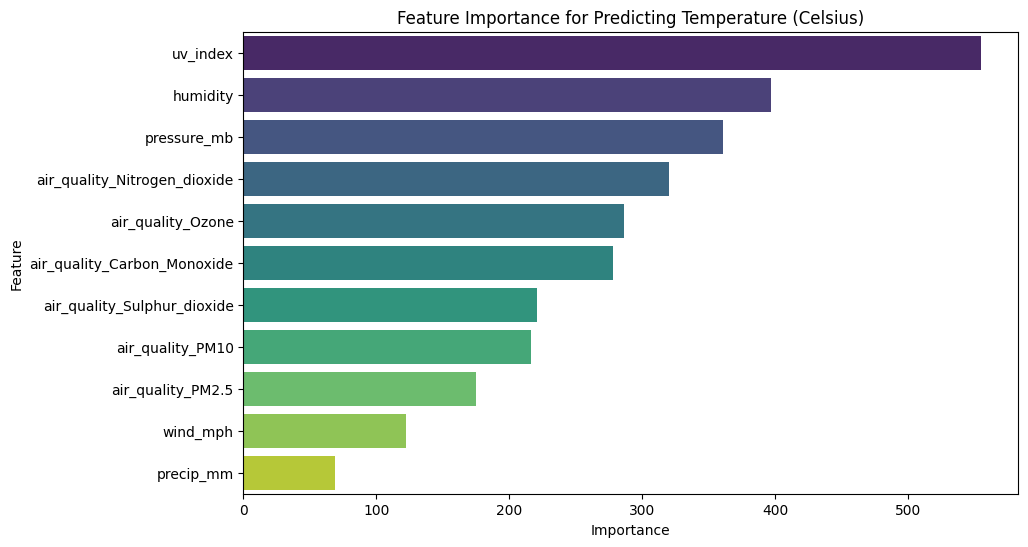

Holt-Winters - MAE: 0.20283600656927822, MSE: 0.053846218412431965, R2: -0.004198660408495147
LGBM - MAE: 0.2518674496384008, MSE: 0.10134055693519371, R2: -0.8899386905854971
XGBoost - MAE: 0.25221161366714256, MSE: 0.10165083660198747, R2: -0.8957252144108054
Predictions saved to 'model_predictions.csv'


In [9]:
hw_model = ExponentialSmoothing(
    train_data,
    seasonal='add',
    seasonal_periods=12,
    trend='add',
    damped_trend=True
).fit()
hw_forecast = hw_model.forecast(len(test_data))

# LGBM Model
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_forecast = lgbm_model.predict(X_test)

# XGBoost Model
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)

feature_importances = lgbm_model.feature_importances_
feature_names = X_train.columns.tolist()  

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Predicting Temperature (Celsius)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Evaluate Models
def evaluate_model(true_values, predictions, model_name):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    print(f"{model_name} - MAE: {mae}, MSE: {mse}, R2: {r2}")

evaluate_model(test_data, hw_forecast, "Holt-Winters")
evaluate_model(test_data, lgbm_forecast, "LGBM")
evaluate_model(test_data, xgb_forecast, "XGBoost")

# Save Predictions
results_df = pd.DataFrame({
    'actual': test_data.values,
    'holt_winters': hw_forecast,
    'lgbm': lgbm_forecast,
    'xgboost': xgb_forecast
})

results_df.to_csv('model_predictions.csv', index=False)
print("Predictions saved to 'model_predictions.csv'")